In [ ]:
from skimage import io
import skimage
import random
import tensorflow as tf
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Softmax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Concatenate, Activation, BatchNormalization, Dropout, Add
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score
from google.colab import drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset Paths
train_image_folder = "/content/drive/My Drive/IP_Data/train_data/Images"
train_label_folder = "/content/drive/My Drive/IP_Data/train_data/Labels"
val_image_folder = "/content/drive/My Drive/IP_Data/val_data/Images"
val_label_folder = "/content/drive/My Drive/IP_Data/val_data/Labels"

IMG_SIZE = (112, 112)
BATCH_SIZE = 8

# Color mapping for segmentation
COLOR_MAPPING = {
    (0, 0, 0): 0,      # Background clutter
    (128, 0, 0): 1,    # Building
    (128, 64, 128): 2, # Road
    (0, 128, 0): 3,    # Tree
    (128, 128, 0): 4,  # Low vegetation
    (64, 0, 128): 5,   # Moving car
    (192, 0, 192): 6,  # Static car
    (64, 64, 0): 7     # Human
}

def load_image_and_mask(image_path, mask_path):
    # Load and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure 3 channels

    # Load and decode mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)  # Ensure 3 channels

    return image, mask

def resize(image, mask):
    image = tf.image.resize(image, IMG_SIZE)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    return image, mask

def augment(image, mask):
    mask = tf.expand_dims(mask, axis=-1)  # Now mask has shape (height, width, 1)

    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)


    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)


    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)


    image = tf.image.random_brightness(image, max_delta=0.2)


    mask = tf.squeeze(mask, axis=-1)

    return image, mask

def normalize(image, mask):
    image = tf.cast(image, tf.float32) / 255.0


    mask = tf.cast(mask, tf.int32)
    mask = tf.reduce_all(
        tf.equal(tf.expand_dims(mask, -2), list(COLOR_MAPPING.keys())), axis=-1
    )
    mask = tf.argmax(mask, axis=-1)

    return image, mask

def process_and_augment(image_path, mask_path):
    """Load, resize, normalize, augment, and convert masks."""
    image, mask = load_image_and_mask(image_path, mask_path)
    image, mask = resize(image, mask)
    image, mask = normalize(image, mask)
    image, mask = augment(image, mask)

    return image, mask

def create_augmented_dataset(image_folder, label_folder):
    """Create a dataset with data augmentation."""
    image_paths = [os.path.join(image_folder, fname) for fname in sorted(os.listdir(image_folder))]
    label_paths = [os.path.join(label_folder, fname) for fname in sorted(os.listdir(label_folder))]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(process_and_augment )
    dataset = dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)
    return dataset

# Create training and validation datasets
train_dataset = create_augmented_dataset(train_image_folder, train_label_folder)

def process_data(image_path, mask_path):
    """Load, resize, and normalize the data."""
    image, mask = load_image_and_mask(image_path, mask_path)
    image, mask = resize(image, mask)
    image, mask = normalize(image, mask)
    return image, mask

def create_dataset(image_folder, label_folder):
    """Create a dataset without augmentation."""
    image_paths = [os.path.join(image_folder, fname) for fname in sorted(os.listdir(image_folder))]
    label_paths = [os.path.join(label_folder, fname) for fname in sorted(os.listdir(label_folder))]

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(process_data)
    dataset = dataset.shuffle(buffer_size=100).batch(BATCH_SIZE)
    return dataset

val_dataset = create_dataset(val_image_folder, val_label_folder)

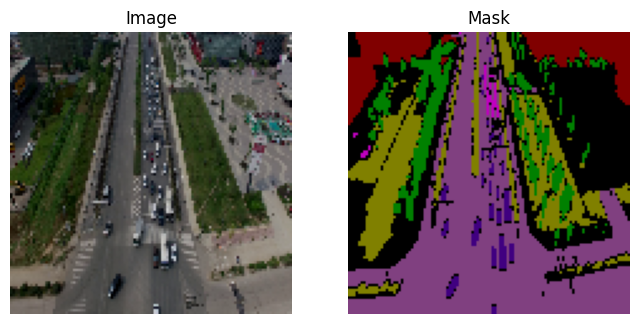

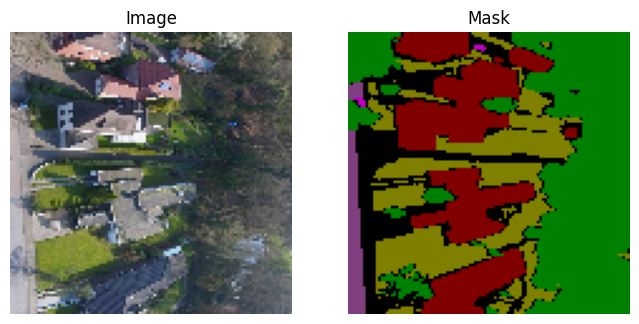

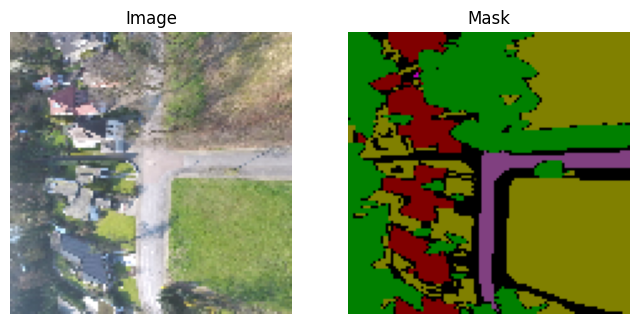

In [ ]:
# Function to map class indices back to their RGB values
def decode_mask(mask):
    height, width = mask.shape
    decoded_mask = np.zeros((height, width, 3), dtype=np.uint8)
    for rgb, class_index in COLOR_MAPPING.items():
        decoded_mask[mask == class_index] = rgb
    return decoded_mask

# Function to visualize the first few samples
def visualize_samples(dataset, num_samples):
    count = 0
    for images, masks in dataset:
        for i in range(len(images)):
            if count >= num_samples:
                return
            image = images[i].numpy()  # Convert tensor to NumPy array
            mask = masks[i].numpy()   # Convert tensor to NumPy array
            mask_rgb = decode_mask(mask)  # Decode mask into RGB

            # Plot the image and its corresponding mask
            plt.figure(figsize=(8, 4))

            # Show the image
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Image")
            plt.axis("off")

            # Show the mask in original colors
            plt.subplot(1, 2, 2)
            plt.imshow(mask_rgb)
            plt.title("Mask")
            plt.axis("off")

            plt.show()

            count += 1
visualize_samples(train_dataset, 3)


In [ ]:
def compute_dataset_metrics(true_masks, pred_masks, num_classes=8):

    # Flatten the masks
    true_masks_flat = true_masks.flatten()
    pred_masks_flat = pred_masks.flatten()

    # Initialize metric storage
    metrics = {
        "iou_per_class": [],
        "precision_per_class": [],
        "recall_per_class": [],
        "dice_per_class": [],
    }

    for class_index in range(num_classes):
        true_class = (true_masks_flat == class_index).astype(int)
        pred_class = (pred_masks_flat == class_index).astype(int)

        # Compute IoU
        metrics["iou_per_class"].append(jaccard_score(true_class, pred_class))

        # Compute Precision
        metrics["precision_per_class"].append(precision_score(true_class, pred_class))

        # Compute Recall
        metrics["recall_per_class"].append(recall_score(true_class, pred_class))

        # Compute Dice (F1 Score)
        metrics["dice_per_class"].append(f1_score(true_class, pred_class))

    # Compute mean for each metric
    metrics["mean_iou"] = np.mean(metrics["iou_per_class"])
    metrics["mean_precision"] = np.mean(metrics["precision_per_class"])
    metrics["mean_recall"] = np.mean(metrics["recall_per_class"])
    metrics["mean_dice"] = np.mean(metrics["dice_per_class"])

    return metrics

In [ ]:
test_image_folder = "/content/drive/My Drive/IP_Data/test_data/Images"


def process_test_image(image_path):
    """Load, resize, and normalize the test image."""
    # Load and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Ensure 3 channels

    # Resize and normalize the image
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]

    return image

def create_test_dataset(image_folder):
    """Create a dataset for test images without labels."""
    # Get all image paths from the test folder
    image_paths = [os.path.join(image_folder, fname) for fname in sorted(os.listdir(image_folder))]

    # Create a dataset from image paths
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(process_test_image)  # Apply preprocessing
    dataset = dataset.batch(BATCH_SIZE)  # Batch the data

    return dataset

# Create the test dataset
test_dataset = create_test_dataset(test_image_folder)

## UNET

In [ ]:
def double_conv_block(inputs, num_filters, dropout_rate=0.0):
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    return x

def encoder_block(inputs, num_filters, dropout_rate=0.0):
    x = double_conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)

    return x, p

def decoder_block(inputs, skip, num_filters, dropout_rate=0.0):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = double_conv_block(x, num_filters, dropout_rate)

    return x


In [ ]:
def build_unet(input_shape, num_of_classes, dropout_rate):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64, dropout_rate)
    s2, p2 = encoder_block(p1, 128, dropout_rate)
    s3, p3 = encoder_block(p2, 256, dropout_rate)
    s4, p4 = encoder_block(p3, 512, dropout_rate)

    # Bridge
    b1 = double_conv_block(p4, 1024, dropout_rate)

    # Decoder
    d1 = decoder_block(b1, s4, 512, dropout_rate)
    d2 = decoder_block(d1, s3, 256, dropout_rate)
    d3 = decoder_block(d2, s2, 128, dropout_rate)
    d4 = decoder_block(d3, s1, 64, dropout_rate)

    outputs = tf.keras.layers.Conv2D(num_of_classes, 1, padding="same", activation="softmax")(d4)
    model = tf.keras.models.Model(inputs, outputs, name="UNET")
    return model

In [ ]:
LEARNING_RATE1 = 0.0001
DROPOUT_RATE1 = 0
unet = build_unet(input_shape=(112, 112, 3), num_of_classes=8, dropout_rate=DROPOUT_RATE1)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE1)
unet.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics=['accuracy'])

EPOCHS1 = 50
unet_model_history = unet.fit(
    train_dataset,
    epochs=EPOCHS1,
    validation_data=val_dataset,
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.2634 - loss: 2.5061 - val_accuracy: 0.2418 - val_loss: 2.5941
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - accuracy: 0.4605 - loss: 2.0012 - val_accuracy: 0.2755 - val_loss: 2.5896
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.5271 - loss: 1.8457 - val_accuracy: 0.2759 - val_loss: 2.5813
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 297ms/step - accuracy: 0.5279 - loss: 1.7860 - val_accuracy: 0.2595 - val_loss: 2.5121
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.5734 - loss: 1.6577 - val_accuracy: 0.2276 - val_loss: 2.6105
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 400ms/step - accuracy: 0.5822 - loss: 1.5907 - val_accuracy: 0.2540 - val_loss: 2.7067
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 317ms/step - accuracy: 0.5762 - loss: 1.5721 - val_accuracy: 0.1923 - val_loss: 2.8239
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 403ms/step - accuracy: 0.5969 - loss: 1.5355 - val_accurac

In [ ]:
unet.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 112, 112, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 93,143,706 (355.32 MB)

 Trainable params: 31,043,976 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 62,087,954 (236.85 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


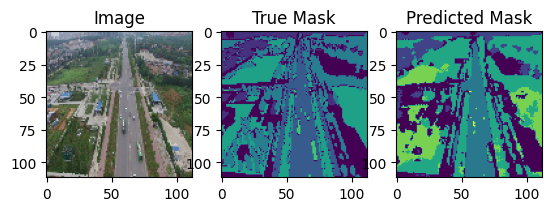

In [ ]:
for image, mask in val_dataset.take(1):
    predictions1 = unet.predict(image)
    predicted_masks1 = tf.argmax(predictions1, axis=-1)

    plt.subplot(1, 3, 1)
    plt.imshow(image[0])
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0])
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks1[0])
    plt.title("Predicted Mask")
    plt.show()


In [ ]:
# Predict on the entire validation dataset
true_masks_all = []
pred_masks_all = []

for images, masks in val_dataset:
    predictions1 = unet.predict(images)
    true_masks_all.append(masks.numpy())
    pred_masks_all.append(tf.argmax(predictions1, axis=-1).numpy())

true_masks_all = np.concatenate(true_masks_all, axis=0)
pred_masks_all = np.concatenate(pred_masks_all, axis=0)

# Compute metrics for the entire dataset
final_metrics1 = compute_dataset_metrics(true_masks_all, pred_masks_all, num_classes=8)

# Print the metrics
print("Final Metrics:")
for metric, value in final_metrics1.items():
    if isinstance(value, list):  # Check if the value is a list (per-class metrics)
        print(f"{metric}: {[f'{v:.4f}' for v in value]}")  # Format each value in the list
    else:  # Scalar values (mean metrics)
        print(f"{metric}: {value:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Metrics:
iou_per_class: ['0.4393', '0.7614', '0.5557', '0.5588', '0.4235', '0.1180', '0.0915', '0.0000']
precision_per_class: ['0.6080', '0.8364', '0.7919', '0.6493', '0.7723', '0.5578', '0.6079', '0.0000']
recall_per_class: ['0.6129', '0.8946', '0.6507', '0.8004', '0.4840', '0.1302', '0.0972', '0.0000']
dice_per_class: ['0.6104', '0.8645', '0.7144', '0.7170', '0.5951', '0.2111', '0.1677', '0.0000']
mean_iou: 0.3685
mean_precision: 0.6030
mean_recall: 0.4588
mean_dice: 0.4850


In [ ]:
from tensorflow.keras.models import load_model

# Specify the directory to save the model
model_save_path = "/content/drive/My Drive/IP_Data/saved_models/unet_model.keras"

# Save the trained model
unet.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

# Load the model for inference or further training
loaded_model1 = load_model(model_save_path)
print("Model loaded successfully.")

# Verify the loaded model
loaded_model1.summary()



Model saved successfully at: /content/drive/My Drive/IP_Data/saved_models/unet_model.keras
Model loaded successfully.


Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 112, 112, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 112, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 56, 56, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 93,143,706 (355.32 MB)

 Trainable params: 31,043,976 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 62,087,954 (236.85 MB)

In [ ]:
loaded_model1.compile(
    optimizer='adam',  # Use the same optimizer as in training
    loss='sparse_categorical_crossentropy',  # Use the same loss function
    metrics=['accuracy']  # Use the same metrics
)

In [ ]:
import cv2  # For saving images
from google.colab import drive


# Directory to save predictions
output_folder = "/content/drive/My Drive/IP_Data/test_predictions/"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Function to save predictions
def save_predictions(dataset, model, output_folder, image_paths):
    """Predict and save the segmentation masks for the test dataset."""
    for batch_idx, images in enumerate(dataset):
        predictions = model.predict(images)
        predicted_masks = tf.argmax(predictions, axis=-1).numpy()  # Convert to NumPy

        for i, mask in enumerate(predicted_masks):
            # Decode the mask to RGB
            mask_rgb = decode_mask(mask)

            # Get the image filename from the image path
            image_filename = os.path.basename(image_paths[batch_idx * BATCH_SIZE + i])
            output_filename = os.path.splitext(image_filename)[0] + "_pred.png"  # Add suffix for prediction
            output_filepath = os.path.join(output_folder, output_filename)

            # Save the decoded mask as an image
            cv2.imwrite(output_filepath, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))  # Save in BGR format for OpenCV
            print(f"Saved: {output_filepath}")

# Create test image paths
test_image_paths = [os.path.join(test_image_folder, fname) for fname in sorted(os.listdir(test_image_folder))]

# Save predictions for the test dataset
save_predictions(test_dataset, loaded_model1, output_folder, test_image_paths)

print(f"Predictions saved successfully in: {output_folder}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000000_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000100_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000200_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000300_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000400_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000500_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000600_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000700_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000800_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq21_000900_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq22_000000_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions/seq22_00010

## RESUNET

In [ ]:
def residual_conv_block(inputs, num_filters, dropout_rate=0.0):
    """Defines a residual convolutional block."""
    # Ensure the input has the same number of filters as the block output
    shortcut = inputs
    if inputs.shape[-1] != num_filters:
        shortcut = Conv2D(num_filters, 1, padding="same")(inputs)

    # First Convolution
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    # Second Convolution
    x = Conv2D(num_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = BatchNormalization()(x)

    # Add residual connection
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)

    return x

def encoder_block_residual(inputs, num_filters, dropout_rate=0.0):
    """Defines an encoder block with residual connections."""
    x = residual_conv_block(inputs, num_filters, dropout_rate)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block_residual(inputs, skip, num_filters, dropout_rate=0.0):
    """Defines a decoder block with residual connections."""
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip])
    x = residual_conv_block(x, num_filters, dropout_rate)
    return x


In [ ]:
def build_residual_unet(input_shape, num_of_classes, dropout_rate=0.0):
    """Builds a U-Net with residual connections."""
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block_residual(inputs, 64, dropout_rate)
    s2, p2 = encoder_block_residual(p1, 128, dropout_rate)
    s3, p3 = encoder_block_residual(p2, 256, dropout_rate)
    s4, p4 = encoder_block_residual(p3, 512, dropout_rate)

    # Bridge
    b1 = residual_conv_block(p4, 1024, dropout_rate)

    # Decoder
    d1 = decoder_block_residual(b1, s4, 512, dropout_rate)
    d2 = decoder_block_residual(d1, s3, 256, dropout_rate)
    d3 = decoder_block_residual(d2, s2, 128, dropout_rate)
    d4 = decoder_block_residual(d3, s1, 64, dropout_rate)

    # Output Layer
    outputs = Conv2D(num_of_classes, 1, padding="same", activation="softmax")(d4)

    # Model
    model = tf.keras.models.Model(inputs, outputs, name="Residual_UNet")
    return model

In [ ]:
LEARNING_RATE2 = 0.0001
DROPOUT_RATE2 = 0

residual_unet = build_residual_unet(input_shape=(112, 112, 3), num_of_classes=8, dropout_rate=DROPOUT_RATE2)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE2)
residual_unet.compile(optimizer=optimizer,
                      loss="sparse_categorical_crossentropy",
                      metrics=['accuracy'])


# Train the residual U-Net model
EPOCHS2 = 40
residual_model_history = residual_unet.fit(
    train_dataset,
    epochs=EPOCHS2,
    validation_data=val_dataset,)


Epoch 1/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 604ms/step - accuracy: 0.1975 - loss: 2.8040 - val_accuracy: 0.2080 - val_loss: 2.5387
Epoch 2/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 332ms/step - accuracy: 0.4752 - loss: 1.9418 - val_accuracy: 0.2660 - val_loss: 2.4401
Epoch 3/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 292ms/step - accuracy: 0.4982 - loss: 1.7675 - val_accuracy: 0.2822 - val_loss: 2.3363
Epoch 4/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 318ms/step - accuracy: 0.5401 - loss: 1.6492 - val_accuracy: 0.2567 - val_loss: 2.3693
Epoch 5/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.5418 - loss: 1.6092 - val_accuracy: 0.2280 - val_loss: 2.3298
Epoch 6/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - accuracy: 0.5729 - loss: 1.5388 - val_accuracy: 0.2597 - val_loss: 2.4099
Epoch 7/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.5866 - loss: 1.4800 - val_accuracy: 0.2300 - val_loss: 3.1991
Epoch 8/40
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 288ms/step - accuracy: 0.6086 - loss: 1.4138 - val_accu

In [ ]:
residual_unet.summary()

Model: "Residual_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 112, 112, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 112, 112, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 112, 112, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 112, 112, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 112, 112, 64)   │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 112, 112, 64)   │              0 │ add[0][0]              │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 64)     │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 56, 56, 128)    │            512 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 56, 56, 128)    │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization) 

 Total params: 97,331,034 (371.29 MB)

 Trainable params: 32,439,752 (123.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 64,879,506 (247.50 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


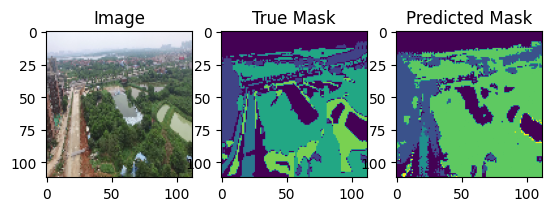

In [ ]:
for image, mask in val_dataset.take(1):
    predictions2 = residual_unet.predict(image)
    predicted_masks2 = tf.argmax(predictions2, axis=-1)

    plt.subplot(1, 3, 1)
    plt.imshow(image[0])
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0])
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks2[0])
    plt.title("Predicted Mask")
    plt.show()


In [ ]:
# Predict on the entire validation dataset
true_masks_all = []
pred_masks_all = []

for images, masks in val_dataset:
    predictions2 = residual_unet.predict(images)
    true_masks_all.append(masks.numpy())
    pred_masks_all.append(tf.argmax(predictions2, axis=-1).numpy())

true_masks_all = np.concatenate(true_masks_all, axis=0)
pred_masks_all = np.concatenate(pred_masks_all, axis=0)

# Compute metrics for the entire dataset
final_metrics2 = compute_dataset_metrics(true_masks_all, pred_masks_all, num_classes=8)

# Print the metrics
print("Final Metrics:")
for metric, value in final_metrics2.items():
    if isinstance(value, list):  # Check if the value is a list (per-class metrics)
        print(f"{metric}: {[f'{v:.4f}' for v in value]}")  # Format each value in the list
    else:  # Scalar values (mean metrics)
        print(f"{metric}: {value:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Metrics:
iou_per_class: ['0.3614', '0.7265', '0.5430', '0.5221', '0.3001', '0.0539', '0.0440', '0.0000']
precision_per_class: ['0.5852', '0.7673', '0.8322', '0.5965', '0.7603', '0.5284', '0.6355', '0.0000']
recall_per_class: ['0.4858', '0.9319', '0.6098', '0.8072', '0.3315', '0.0566', '0.0451', '0.0000']
dice_per_class: ['0.5309', '0.8416', '0.7038', '0.6860', '0.4617', '0.1023', '0.0843', '0.0000']
mean_iou: 0.3189
mean_precision: 0.5882
mean_recall: 0.4085
mean_dice: 0.4263


In [ ]:
from tensorflow.keras.models import load_model

# Specify the directory to save the model
model_save_path = "/content/drive/My Drive/IP_Data/saved_models/residual_unet_model.keras"

# Save the trained model
residual_unet.save(model_save_path)
print(f"Model saved successfully at: {model_save_path}")

# Load the model for inference or further training
loaded_model2 = load_model(model_save_path)
print("Model loaded successfully.")

# Verify the loaded model
loaded_model2.summary()



Model saved successfully at: /content/drive/My Drive/IP_Data/saved_models/residual_unet_model.keras
Model loaded successfully.


Model: "Residual_UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 112, 112, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 112, 112, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 112, 112, 64)   │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 112, 112, 64)   │         36,928 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 112, 112, 64)   │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_19 (Conv2D)        │ (None, 112, 112, 64)   │            256 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 112, 112, 64)   │              0 │ batch_normalization_1… │
│                           │                        │                │ conv2d_19[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 112, 112, 64)   │              0 │ add[0][0]              │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 56, 56, 64)     │              0 │ activation_19[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 56, 56, 128)    │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 56, 56, 128)    │            512 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_20             │ (None, 56, 56, 128)    │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 56, 56, 128)    │        147,584 │ activation_20[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 56, 56, 128)    │            512 │ conv2d_24[0][0]        │
│ (BatchNormalization) 

 Total params: 97,331,034 (371.29 MB)

 Trainable params: 32,439,752 (123.75 MB)

 Non-trainable params: 11,776 (46.00 KB)

 Optimizer params: 64,879,506 (247.50 MB)

In [ ]:
loaded_model2.compile(
    optimizer='adam',  # Use the same optimizer as in training
    loss='sparse_categorical_crossentropy',  # Use the same loss function
    metrics=['accuracy']  # Use the same metrics
)

In [ ]:
import cv2  # For saving images
from google.colab import drive


# Directory to save predictions
output_folder = "/content/drive/My Drive/IP_Data/test_predictions2/"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Function to save predictions
def save_predictions(dataset, model, output_folder, image_paths):
    """Predict and save the segmentation masks for the test dataset."""
    for batch_idx, images in enumerate(dataset):
        predictions = model.predict(images)
        predicted_masks = tf.argmax(predictions, axis=-1).numpy()  # Convert to NumPy

        for i, mask in enumerate(predicted_masks):
            # Decode the mask to RGB
            mask_rgb = decode_mask(mask)

            # Get the image filename from the image path
            image_filename = os.path.basename(image_paths[batch_idx * BATCH_SIZE + i])
            output_filename = os.path.splitext(image_filename)[0] + "_pred.png"  # Add suffix for prediction
            output_filepath = os.path.join(output_folder, output_filename)

            # Save the decoded mask as an image
            cv2.imwrite(output_filepath, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))  # Save in BGR format for OpenCV
            print(f"Saved: {output_filepath}")

# Create test image paths
test_image_paths = [os.path.join(test_image_folder, fname) for fname in sorted(os.listdir(test_image_folder))]

# Save predictions for the test dataset
save_predictions(test_dataset, loaded_model2, output_folder, test_image_paths)

print(f"Predictions saved successfully in: {output_folder}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000000_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000100_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000200_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000300_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000400_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000500_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000600_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000700_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000800_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq21_000900_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/seq22_000000_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions2/

## SEGNET

In [ ]:
def build_segnet(input_shape, num_classes, dropout_rate):
    """Builds the SegNet architecture."""
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2)(x)  # Downsampling

    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2)(x)  # Downsampling

    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2)(x)  # Downsampling

    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=2)(x)  # Downsampling

    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)  # Add Dropout
    x = Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)

    # Output Layer
    outputs = Conv2D(num_classes, (1, 1), padding="same", activation="softmax")(x)

    # Create Model
    model = Model(inputs, outputs, name="SegNet")
    return model

In [ ]:
# Build SegNet Model
LEARNING_RATE3 = 0.0001
DROPOUT_RATE3 = 0
segnet = build_segnet(input_shape=(112, 112, 3), num_classes=8, dropout_rate=DROPOUT_RATE3)

# Compile SegNet
segnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE3),
               loss="sparse_categorical_crossentropy",
               metrics=["accuracy"])


# Train the Model
EPOCHS3 = 50
segnet_history = segnet.fit(
    train_dataset,
    epochs=EPOCHS3,
    validation_data=val_dataset
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 578ms/step - accuracy: 0.2173 - loss: 2.3704 - val_accuracy: 0.3125 - val_loss: 2.0284
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 378ms/step - accuracy: 0.4342 - loss: 1.7154 - val_accuracy: 0.2338 - val_loss: 2.0324
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.4743 - loss: 1.5885 - val_accuracy: 0.2150 - val_loss: 2.6202
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.4899 - loss: 1.5212 - val_accuracy: 0.2143 - val_loss: 3.3100
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.5112 - loss: 1.4527 - val_accuracy: 0.2133 - val_loss: 5.0423
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.5240 - loss: 1.4013 - val_accuracy: 0.2141 - val_loss: 7.0963
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 302ms/step - accuracy: 0.5272 - loss: 1.3781 - val_accuracy: 0.2141 - val_loss: 9.0367
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 300ms/step - accuracy: 0.5436 - loss: 1.3269 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


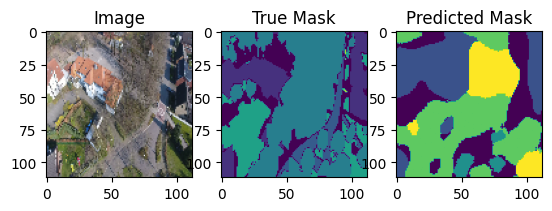

In [ ]:
# Visualize predictions
for image, mask in val_dataset.take(1):
    predictions3 = segnet.predict(image)
    predicted_masks3 = tf.argmax(predictions3, axis=-1)

    plt.subplot(1, 3, 1)
    plt.imshow(image[0])
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[0])
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(predicted_masks3[0])
    plt.title("Predicted Mask")
    plt.show()

In [ ]:
segnet.summary()

Model: "SegNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 112, 112, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 112, 112, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 256)         │              

 Total params: 52,928,858 (201.91 MB)

 Trainable params: 17,639,368 (67.29 MB)

 Non-trainable params: 10,752 (42.00 KB)

 Optimizer params: 35,278,738 (134.58 MB)

In [ ]:
# Predict on the entire validation dataset
true_masks_all = []
pred_masks_all = []

for images, masks in val_dataset:
    predictions3 = segnet.predict(images)
    true_masks_all.append(masks.numpy())
    pred_masks_all.append(tf.argmax(predictions3, axis=-1).numpy())

true_masks_all = np.concatenate(true_masks_all, axis=0)
pred_masks_all = np.concatenate(pred_masks_all, axis=0)

# Compute metrics for the entire dataset
final_metrics3 = compute_dataset_metrics(true_masks_all, pred_masks_all, num_classes=8)

# Print the metrics
print("Final Metrics:")
for metric, value in final_metrics3.items():
    if isinstance(value, list):  # Check if the value is a list (per-class metrics)
        print(f"{metric}: {[f'{v:.4f}' for v in value]}")  # Format each value in the list
    else:  # Scalar values (mean metrics)
        print(f"{metric}: {value:.4f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Final Metrics:
iou_per_class: ['0.3391', '0.7028', '0.4985', '0.4210', '0.2554', '0.0000', '0.0000', '0.0000']
precision_per_class: ['0.5491', '0.7976', '0.6255', '0.5288', '0.5363', '0.0000', '0.0000', '0.0000']
recall_per_class: ['0.4700', '0.8553', '0.7107', '0.6736', '0.3277', '0.0000', '0.0000', '0.0000']
dice_per_class: ['0.5065', '0.8255', '0.6654', '0.5925', '0.4068', '0.0000', '0.0000', '0.0000']
mean_iou: 0.2771
mean_precision: 0.3797
mean_recall: 0.3797
mean_dice: 0.3746


In [ ]:
from tensorflow.keras.models import load_model

# Specify the directory to save the model
model_save_path = "/content/drive/My Drive/IP_Data/saved_models/segnet_model.keras"

# Save and evaluate the model
segnet.save(model_save_path)
print(f"segnet model saved successfully at: {model_save_path}")
loaded_segnet = load_model(model_save_path)
print("Model loaded successfully.")
loaded_segnet.summary()

segnet model saved successfully at: /content/drive/My Drive/IP_Data/saved_models/segnet_model.keras
Model loaded successfully.


Model: "SegNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 112, 112, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 112, 112, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 256)         │              

 Total params: 52,928,858 (201.91 MB)

 Trainable params: 17,639,368 (67.29 MB)

 Non-trainable params: 10,752 (42.00 KB)

 Optimizer params: 35,278,738 (134.58 MB)

In [ ]:
loaded_segnet.compile(
    optimizer='adam',  # Use the same optimizer as in training
    loss='sparse_categorical_crossentropy',  # Use the same loss function
    metrics=['accuracy']  # Use the same metrics
)

In [ ]:
import cv2  # For saving images
from google.colab import drive


# Directory to save predictions
output_folder = "/content/drive/My Drive/IP_Data/test_predictions3/"
os.makedirs(output_folder, exist_ok=True)  # Create folder if it doesn't exist

# Function to save predictions
def save_predictions(dataset, model, output_folder, image_paths):
    """Predict and save the segmentation masks for the test dataset."""
    for batch_idx, images in enumerate(dataset):
        predictions = model.predict(images)
        predicted_masks = tf.argmax(predictions, axis=-1).numpy()  # Convert to NumPy

        for i, mask in enumerate(predicted_masks):
            # Decode the mask to RGB
            mask_rgb = decode_mask(mask)

            # Get the image filename from the image path
            image_filename = os.path.basename(image_paths[batch_idx * BATCH_SIZE + i])
            output_filename = os.path.splitext(image_filename)[0] + "_pred.png"  # Add suffix for prediction
            output_filepath = os.path.join(output_folder, output_filename)

            # Save the decoded mask as an image
            cv2.imwrite(output_filepath, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))  # Save in BGR format for OpenCV
            print(f"Saved: {output_filepath}")

# Create test image paths
test_image_paths = [os.path.join(test_image_folder, fname) for fname in sorted(os.listdir(test_image_folder))]

# Save predictions for the test dataset
save_predictions(test_dataset, loaded_segnet, output_folder, test_image_paths)

print(f"Predictions saved successfully in: {output_folder}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000000_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000100_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000200_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000300_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000400_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000500_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000600_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000700_pred.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000800_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq21_000900_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/seq22_000000_pred.png
Saved: /content/drive/My Drive/IP_Data/test_predictions3/